/tmp/ipython-input-2-1710981581.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)


Akurasi Model SVM (Fokus Sentimen): 0.625

Laporan Klasifikasi (Fokus Sentimen):
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.33      0.50      0.40         2

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8


Visualisasi telah disimpan sebagai 'sentiment_focused_prediction_visualization.png'


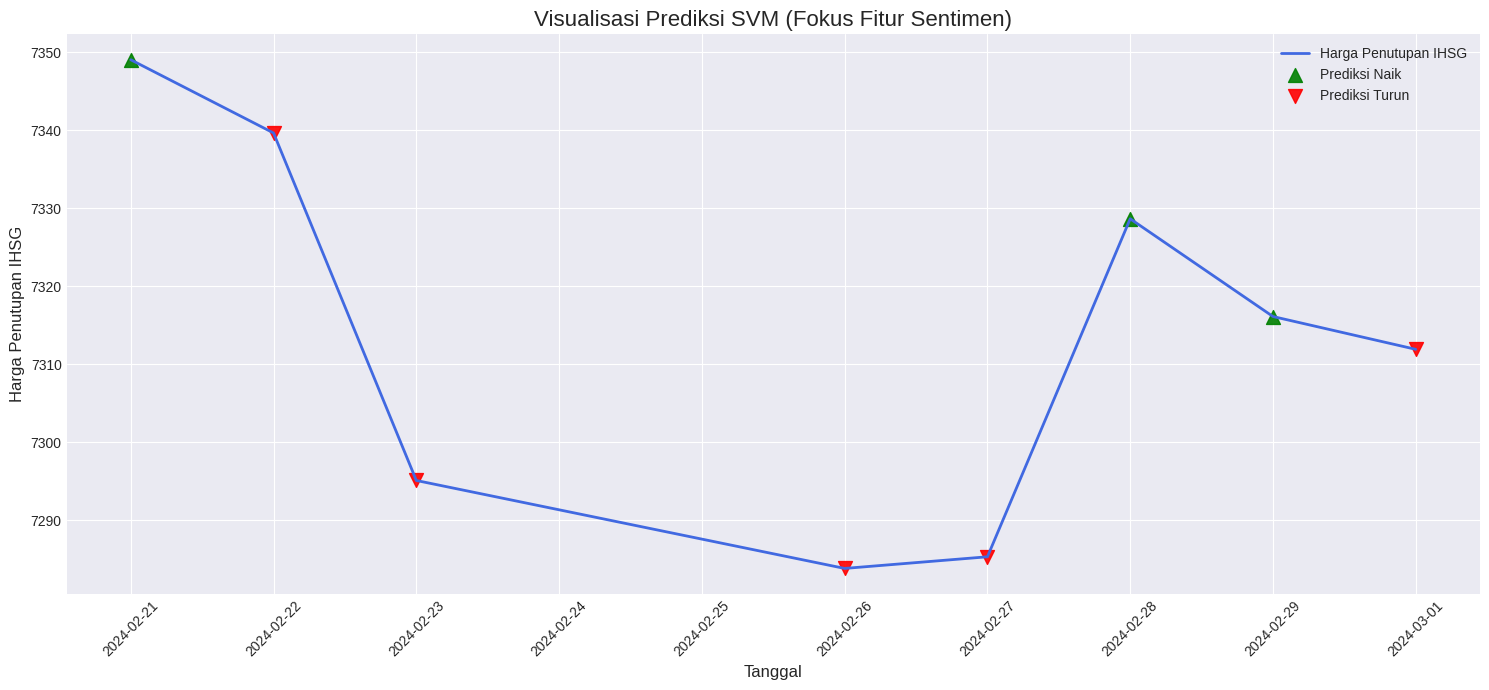

In [ ]:
# Step 1: Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# --- PREPROCESSING DATA SENTIMEN ---

# Step 2: Load dataset sentimen
sentiment_df = pd.read_csv("IDSMSA.csv")
sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)
sentiment_df['Date'] = sentiment_df['Tweet Date'].dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Step 3: Ubah sentimen ke skor dan one-hot encode
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
sentiment_df['Sentiment Score'] = sentiment_df['Sentiment'].map(sentiment_map)
sentiment_df.dropna(subset=['Sentiment Score'], inplace=True)

# Step 4: Buat fitur sentimen yang lebih kaya dengan agregasi harian
sentiment_df['is_positive'] = (sentiment_df['Sentiment'] == 'Positive').astype(int)
sentiment_df['is_negative'] = (sentiment_df['Sentiment'] == 'Negative').astype(int)
sentiment_df['is_neutral'] = (sentiment_df['Sentiment'] == 'Neutral').astype(int)

daily_sentiment_features = sentiment_df.groupby('Date').agg(
    mean_sentiment=('Sentiment Score', 'mean'),
    tweet_volume=('Sentiment', 'count'),
    positive_volume=('is_positive', 'sum'),
    negative_volume=('is_negative', 'sum'),
    neutral_volume=('is_neutral', 'sum')
).reset_index()

# Step 5: Rekayasa Fitur Tambahan dari data sentimen
daily_sentiment_features['pos_neg_ratio'] = daily_sentiment_features['positive_volume'] / (daily_sentiment_features['negative_volume'] + 1)
daily_sentiment_features['positive_percent'] = daily_sentiment_features['positive_volume'] / daily_sentiment_features['tweet_volume']
daily_sentiment_features['negative_percent'] = daily_sentiment_features['negative_volume'] / daily_sentiment_features['tweet_volume']

# --- PREPROCESSING DATA IHSG ---

# Step 6: Load data IHSG
ihsg_df = pd.read_csv("IHSG_2024_2025.csv", skiprows=3)
ihsg_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
ihsg_df['Date'] = pd.to_datetime(ihsg_df['Date'])
ihsg_df = ihsg_df.sort_values('Date').reset_index(drop=True)

# Step 7: Buat label 'NaikTurun'
ihsg_df['Label NaikTurun'] = (ihsg_df['Close'].diff() > 0).astype(int)

# --- PENGGABUNGAN DAN PERSIAPAN DATA AKHIR ---

# Step 8: Gabungkan fitur sentimen harian dengan data IHSG
merged_df = pd.merge(daily_sentiment_features, ihsg_df[['Date', 'Close', 'Label NaikTurun']],
                     on='Date').dropna()

# Step 9: Membuat Fitur Lag (sentiment hari sebelumnya)
merged_df['mean_sentiment_lag1'] = merged_df['mean_sentiment'].shift(1)
merged_df.dropna(inplace=True)

# Step 10: Siapkan data fitur (X) dan target (y)
sentiment_feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1'
]
X = merged_df[sentiment_feature_columns]
y = merged_df['Label NaikTurun']

# Step 11: Penskalaan Fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 12: Split data training/testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# --- PELATIHAN DAN EVALUASI MODEL SVM ---

# Step 13: Latih model SVM dengan class_weight
model = SVC(kernel='rbf', random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 14: Evaluasi model
y_pred = model.predict(X_test)
print("Akurasi Model SVM (Fokus Sentimen):", accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi (Fokus Sentimen):\n", classification_report(y_test, y_pred, zero_division=0))

# --- VISUALISASI HASIL ---

# Step 15: Siapkan data untuk plot
test_df = merged_df.iloc[-len(y_test):].copy()
test_df['Prediction'] = y_pred

# Step 16: Buat plot
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(15, 7))
plt.plot(test_df['Date'], test_df['Close'], label='Harga Penutupan IHSG', color='royalblue', linewidth=2)
plt.scatter(test_df[test_df['Prediction'] == 1]['Date'],
            test_df[test_df['Prediction'] == 1]['Close'],
            label='Prediksi Naik', marker='^', color='green', s=100, alpha=0.9)
plt.scatter(test_df[test_df['Prediction'] == 0]['Date'],
            test_df[test_df['Prediction'] == 0]['Close'],
            label='Prediksi Turun', marker='v', color='red', s=100, alpha=0.9)
plt.title('Visualisasi Prediksi SVM (Fokus Fitur Sentimen)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan IHSG', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sentiment_focused_prediction_visualization.png')
print("\nVisualisasi telah disimpan sebagai 'sentiment_focused_prediction_visualization.png'")

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Gunakan fitur dan label yang sama seperti sebelumnya
sentiment_feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1'
]
X = merged_df[sentiment_feature_columns]
y = merged_df['Label NaikTurun']

# Skala fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inisialisasi model SVM dengan class_weight='balanced' agar lebih adil jika data tidak seimbang
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Lakukan cross-validation dengan 5-fold
svm_cv_scores = cross_val_score(svm_model, X_scaled, y, cv=5, scoring='accuracy')

# Cetak hasil
print("Cross-validation scores (SVM):", svm_cv_scores)
print("Rata-rata akurasi CV (SVM):", svm_cv_scores.mean())

Cross-validation scores (SVM): [0.5        0.5        0.25       0.5        0.57142857]
Rata-rata akurasi CV (SVM): 0.46428571428571425


/tmp/ipython-input-2-3739641379.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)


Akurasi Model Naive Bayes (Fokus Sentimen): 0.625

Laporan Klasifikasi Naive Bayes:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.33      0.50      0.40         2

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8


Visualisasi telah disimpan sebagai 'sentiment_focused_prediction_visualization_nb.png'


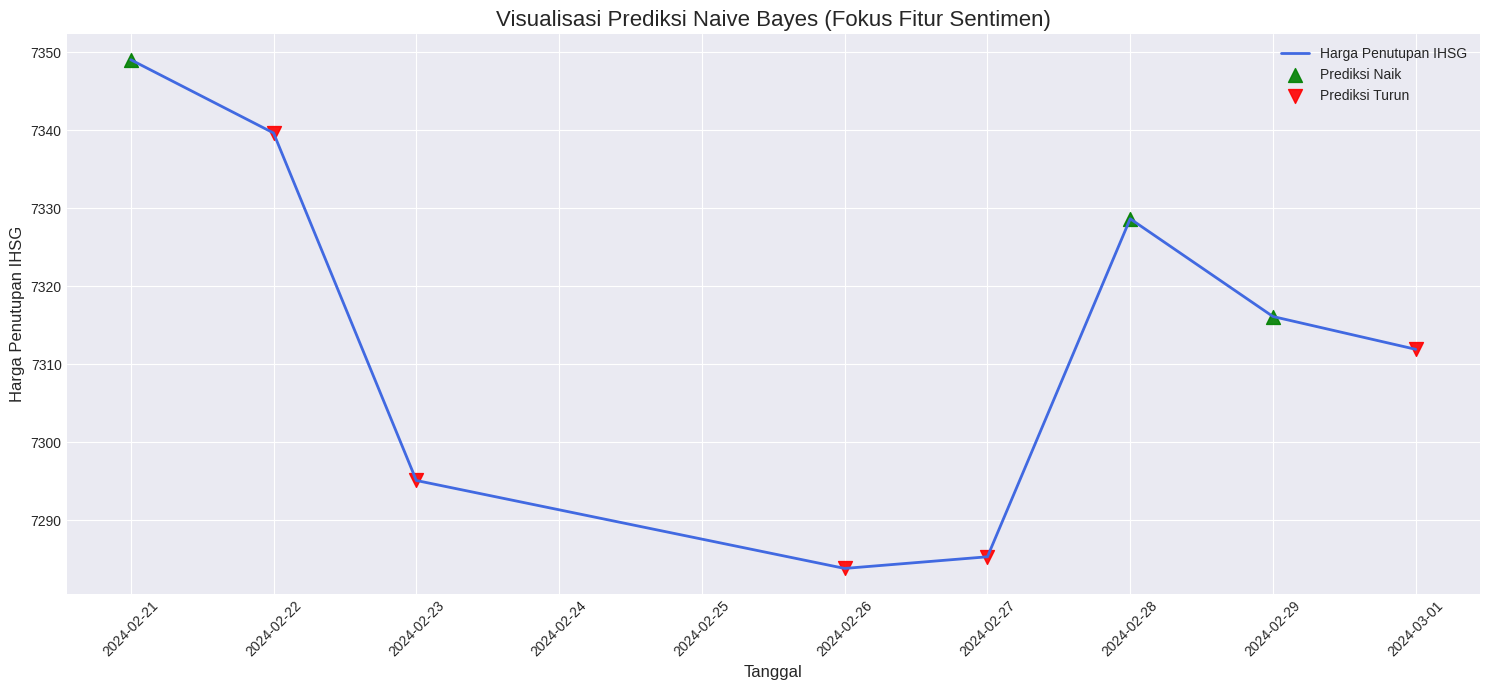

In [2]:
# Step 1: Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# --- PREPROCESSING DATA SENTIMEN ---

# Step 2: Load dataset sentimen
sentiment_df = pd.read_csv("IDSMSA.csv")
sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)
sentiment_df['Date'] = sentiment_df['Tweet Date'].dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Step 3: Ubah sentimen ke skor dan one-hot encode
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
sentiment_df['Sentiment Score'] = sentiment_df['Sentiment'].map(sentiment_map)
sentiment_df.dropna(subset=['Sentiment Score'], inplace=True)

# Step 4: Buat fitur sentimen yang lebih kaya dengan agregasi harian
sentiment_df['is_positive'] = (sentiment_df['Sentiment'] == 'Positive').astype(int)
sentiment_df['is_negative'] = (sentiment_df['Sentiment'] == 'Negative').astype(int)
sentiment_df['is_neutral'] = (sentiment_df['Sentiment'] == 'Neutral').astype(int)

daily_sentiment_features = sentiment_df.groupby('Date').agg(
    mean_sentiment=('Sentiment Score', 'mean'),
    tweet_volume=('Sentiment', 'count'),
    positive_volume=('is_positive', 'sum'),
    negative_volume=('is_negative', 'sum'),
    neutral_volume=('is_neutral', 'sum')
).reset_index()

# Step 5: Rekayasa Fitur Tambahan dari data sentimen
daily_sentiment_features['pos_neg_ratio'] = daily_sentiment_features['positive_volume'] / (daily_sentiment_features['negative_volume'] + 1)
daily_sentiment_features['positive_percent'] = daily_sentiment_features['positive_volume'] / daily_sentiment_features['tweet_volume']
daily_sentiment_features['negative_percent'] = daily_sentiment_features['negative_volume'] / daily_sentiment_features['tweet_volume']

# --- PREPROCESSING DATA IHSG ---

# Step 6: Load data IHSG
ihsg_df = pd.read_csv("IHSG_2024_2025.csv", skiprows=3)
ihsg_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
ihsg_df['Date'] = pd.to_datetime(ihsg_df['Date'])
ihsg_df = ihsg_df.sort_values('Date').reset_index(drop=True)

# Step 7: Buat label 'NaikTurun'
ihsg_df['Label NaikTurun'] = (ihsg_df['Close'].diff() > 0).astype(int)

# --- PENGGABUNGAN DAN PERSIAPAN DATA AKHIR ---

# Step 8: Gabungkan fitur sentimen harian dengan data IHSG
merged_df = pd.merge(daily_sentiment_features, ihsg_df[['Date', 'Close', 'Label NaikTurun']],
                     on='Date').dropna()

# Step 9: Membuat Fitur Lag (sentiment hari sebelumnya)
merged_df['mean_sentiment_lag1'] = merged_df['mean_sentiment'].shift(1)
merged_df.dropna(inplace=True)

# Step 10: Siapkan data fitur (X) dan target (y)
sentiment_feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1'
]
X = merged_df[sentiment_feature_columns]
y = merged_df['Label NaikTurun']

# Step 11: Penskalaan Fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 12: Split data training/testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# --- PELATIHAN DAN EVALUASI MODEL NAIVE BAYES ---

# Step 13: Latih model Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Step 14: Evaluasi model
y_pred_nb = model_nb.predict(X_test)
print("Akurasi Model Naive Bayes (Fokus Sentimen):", accuracy_score(y_test, y_pred_nb))
print("\nLaporan Klasifikasi Naive Bayes:\n", classification_report(y_test, y_pred_nb, zero_division=0))

# --- VISUALISASI HASIL ---

# Step 15: Siapkan data untuk plot
test_df = merged_df.iloc[-len(y_test):].copy()
test_df['Prediction'] = y_pred_nb

# Step 16: Buat plot
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(15, 7))
plt.plot(test_df['Date'], test_df['Close'], label='Harga Penutupan IHSG', color='royalblue', linewidth=2)
plt.scatter(test_df[test_df['Prediction'] == 1]['Date'],
            test_df[test_df['Prediction'] == 1]['Close'],
            label='Prediksi Naik', marker='^', color='green', s=100, alpha=0.9)
plt.scatter(test_df[test_df['Prediction'] == 0]['Date'],
            test_df[test_df['Prediction'] == 0]['Close'],
            label='Prediksi Turun', marker='v', color='red', s=100, alpha=0.9)
plt.title('Visualisasi Prediksi Naive Bayes (Fokus Fitur Sentimen)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan IHSG', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sentiment_focused_prediction_visualization_nb.png')
print("\nVisualisasi telah disimpan sebagai 'sentiment_focused_prediction_visualization_nb.png'")

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Gunakan kembali fitur dan label dari data final yang telah disiapkan
# Pastikan X dan y sudah didefinisikan sebelumnya, jika belum:
sentiment_feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1'
]
X = merged_df[sentiment_feature_columns]
y = merged_df['Label NaikTurun']

# Skala data terlebih dahulu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# Lakukan cross-validation dengan 5-fold
cv_scores = cross_val_score(nb_model, X_scaled, y, cv=5, scoring='accuracy')

# Cetak hasil
print("Cross-validation scores (Naive Bayes):", cv_scores)
print("Rata-rata akurasi CV (Naive Bayes):", cv_scores.mean())

Cross-validation scores (Naive Bayes): [0.5        0.625      0.125      0.75       0.71428571]
Rata-rata akurasi CV (Naive Bayes): 0.5428571428571429


In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Siapkan fitur dan label
sentiment_feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1'
]
X = merged_df[sentiment_feature_columns]
y = merged_df['Label NaikTurun']

# 2. Standardisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Inisialisasi model
nb_model = GaussianNB()
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# 4. Lakukan cross-validation
nb_scores = cross_val_score(nb_model, X_scaled, y, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_model, X_scaled, y, cv=5, scoring='accuracy')

# 5. Cetak hasil
print("Cross-Validation Accuracy Scores:")
print(f"Naive Bayes: {nb_scores}")
print(f"SVM       : {svm_scores}")

print("\nRata-rata Akurasi:")
print(f"Naive Bayes: {np.mean(nb_scores):.4f}")
print(f"SVM       : {np.mean(svm_scores):.4f}")

# 6. Bandingkan dan tentukan model terbaik
if np.mean(svm_scores) > np.mean(nb_scores):
    print("\n✅ Model terbaik berdasarkan cross-validation: SVM")
elif np.mean(svm_scores) < np.mean(nb_scores):
    print("\n✅ Model terbaik berdasarkan cross-validation: Naive Bayes")
else:
    print("\n Kedua model memiliki performa yang sama berdasarkan cross-validation")

Cross-Validation Accuracy Scores:
Naive Bayes: [0.5        0.625      0.125      0.75       0.71428571]
SVM       : [0.5        0.5        0.25       0.5        0.57142857]

Rata-rata Akurasi:
Naive Bayes: 0.5429
SVM       : 0.4643

✅ Model terbaik berdasarkan cross-validation: Naive Bayes
